In [1]:
import numpy as np
import pandas as pd
import torch
from permetrics import RegressionMetric

from experiment_runner import (
    ControlConfig,
    ProposedMethodConfig,
    run_comparison_experiments,
)
from svd_based_optimizer import SvdOptimizer
from ols_optimizer import OlsOptimizer
import matplotlib.pyplot as plt
from dimension_estimation import estimate_dimension, OptimalDimensionSelectionMethod, CaoEstimator
from lag_estimation import estimate_tau, OptimalLagSelectionMethod, AmiEstimator

## Loading the dataset

In [2]:
dataset = pd.read_csv(r".\data\SeriesReport-Seasonally Adjusted Sales - Monthly (Millions of Dollars).csv")
dataset.head()

,Period,Value
0,01-01-1992,164095.0
1,01-02-1992,164213.0
2,01-03-1992,163721.0
3,01-04-1992,164709.0
4,01-05-1992,165612.0


In [3]:
dataset.describe()

,Value
count,341.000000
mean,334938.158358
std,100739.123688
min,163721.000000
25%,249520.000000
50%,340517.000000
75%,414137.000000
max,529616.000000


In [4]:
time_series = dataset['Value'].values
time_series = time_series[np.nonzero(~np.isnan(time_series))]

In [22]:
time_series_mu = np.mean(time_series)
time_series_std = np.std(time_series)

time_series = np.diff(time_series, prepend=time_series[0])
time_series = (time_series - time_series_mu) / time_series_std

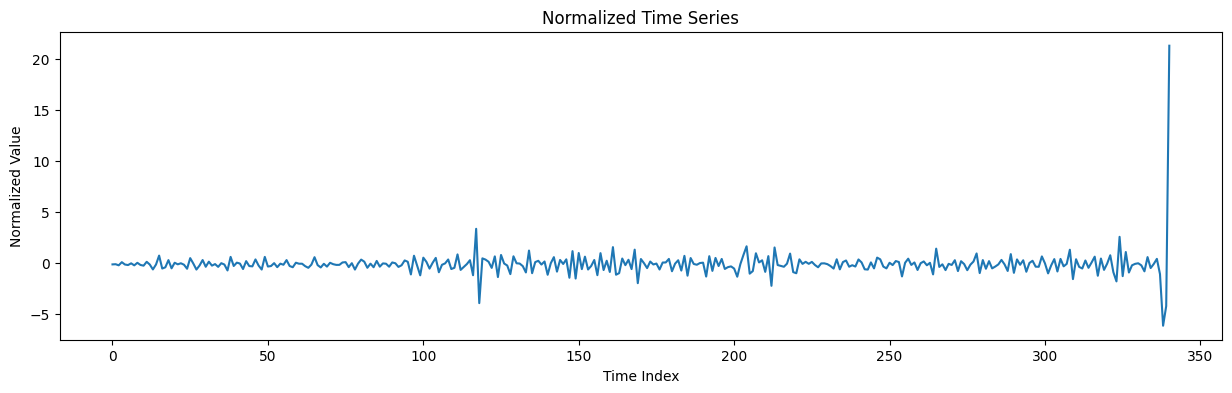

In [23]:
plt.figure(figsize=(15, 4))
plt.plot(time_series)
plt.title('Normalized Time Series')
plt.xlabel('Time Index')
plt.ylabel('Normalized Value')
plt.show()

## Estimating the embedding parameters

In [24]:
tau = estimate_tau(
    time_series,
    estimator=AmiEstimator(
        max_lag=20, optimum_selection_method=OptimalLagSelectionMethod.FIRST_LOC_MIN
    ),
)
print(f"Estimated tau: {tau}")

Estimated tau: 2


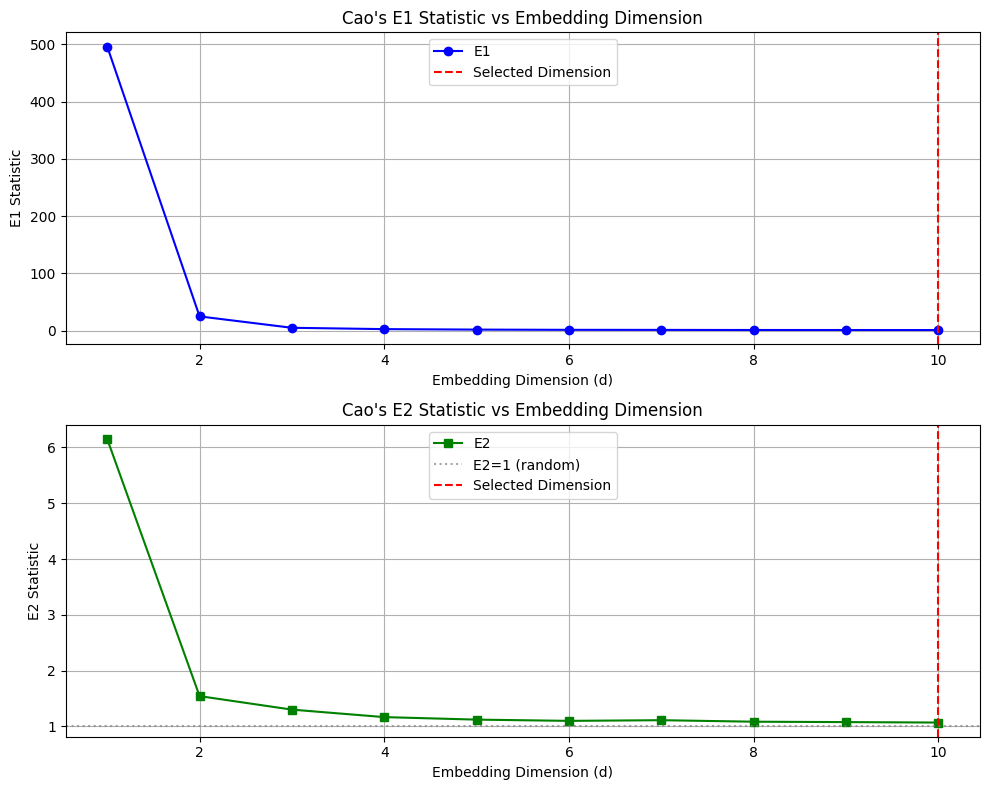

Estimated dimension: 10


In [25]:
dim = estimate_dimension(
    time_series,
    estimator=CaoEstimator(
        delay=tau,
        max_dim=10,
        optimum_selection_method=OptimalDimensionSelectionMethod.E1_E2_COMBINED,
        plot=True,
    ),
)
print(f"Estimated dimension: {dim}")

## Configuring the models

In [32]:
configs = [
        *[
            ProposedMethodConfig(
                approach="no_pretraining",
                optimizer=SvdOptimizer(epsilon=0.05, alpha=alpha),
                m=m,
                post_tune=post_tune,
                n=dim,
                embedding_tau=tau
            )
            for m in [2, 5, 10, 20, 30, 50, 100]
            for alpha in [1e-4, 1e-2, 1e-1, 5e-1, 1, 2, 5]
            for post_tune in [True, False]
        ],
        *[
            ProposedMethodConfig(
                approach="pretraining",
                optimizer=OlsOptimizer(rho=rho),
                m=100,
                n=dim,
                embedding_tau=tau,
                post_tune=post_tune,
            )
            for rho in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
            for post_tune in [True, False]
        ]
    ]

control_config = ControlConfig(m=47, n=dim, embedding_tau=tau)

In [33]:
proposed_results, control_result = run_comparison_experiments(
        time_series,
        configs,
        control_config,
        train_ratio=0.75,
        device="cuda" if torch.cuda.is_available() else "cpu",
        run_parallel=False,
        show_progress=True,
    )

if not isinstance(proposed_results, list):
    proposed_results = [proposed_results]

Running Experiments: 100%|██████████| 113/113 [00:30<00:00,  3.65experiment/s]


In [34]:
results_df = pd.DataFrame(
    {
        "Type": [],
        "Name": [],
        "Test R": [],
        "Test R^2": [],
        "Test NRMSE": [],
    }
)

for res in proposed_results:
    test_metrics = RegressionMetric(
        y_pred=res.test_predictions,
        y_true=res.test_targets,
    )

    new_row = pd.DataFrame(
        {
            "Type": ["Proposed"],
            "Name": [
                f"{res.method_name} (m={res.metadata['total_centers']}, alpha={res.metadata['optimizer_params']['_alpha']})" if res.metadata["optimizer_type"] == "SvdOptimizer" else
                f"{res.method_name} (|C|={res.metadata['selected_centers']}, rho={res.metadata['optimizer_params']['_rho']})"
            ],
            "Test R": [test_metrics.pearson_correlation_coefficient()],
            "Test R^2": [test_metrics.R2()],
            "Test NRMSE": [test_metrics.normalized_root_mean_square_error()],
        }
    )
    results_df = pd.concat([results_df, new_row], ignore_index=True)

control_test_metrics = RegressionMetric(
    y_pred=control_result.test_predictions,
    y_true=control_result.test_targets,
)

new_row = pd.DataFrame(
    {
        "Type": ["Control"],
        "Name": ["Control (m=20)"],
        "Test R": [control_test_metrics.pearson_correlation_coefficient()],
        "Test R^2": [control_test_metrics.R2()],
        "Test NRMSE": [control_test_metrics.normalized_root_mean_square_error()],
    }
)
results_df = pd.concat([results_df, new_row], ignore_index=True)

In [35]:
PROPOSED_MODEL_SELECTION_CRITERION = "Test R^2"
PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE = True

In [36]:
results_df.sort_values(by=["Type", PROPOSED_MODEL_SELECTION_CRITERION], ascending=[True, not PROPOSED_MODEL_SELECTION_CRITERION_SHOULD_MAXIMIZE]).head(10)

,Type,Name,Test R,Test R^2,Test NRMSE
112,Control,Control (m=20),0.068618,0.002745,20.332313
111,Proposed,"PROPOSED-pretraining-OlsOptimizer (|C|=46, rho...",0.595688,0.265823,2.857246
88,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=100, a...",0.289401,0.076872,4.133674
76,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=50, al...",0.269372,0.064351,4.817442
29,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=10, al...",0.253629,0.062495,3.627653
90,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=100, a...",0.235060,0.049090,4.951145
93,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=100, a...",0.215543,0.040360,5.721415
102,Proposed,"PROPOSED-pretraining-OlsOptimizer (|C|=122, rh...",0.302417,0.034020,1.817434
75,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=50, al...",0.197059,0.033116,4.874245
19,Proposed,"PROPOSED-no_pretraining-SvdOptimizer (m=5, alp...",0.206621,0.033107,8.082622


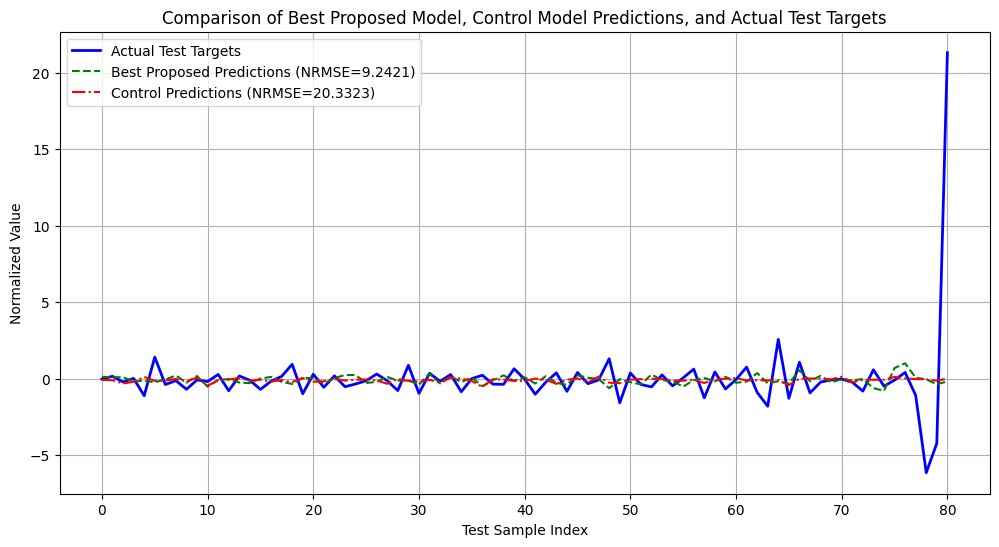

In [ ]:
# Find the index of the best proposed model based on lowest Test NRMSE
best_idx = results_df[results_df["Type"] == "Proposed"][
    PROPOSED_MODEL_SELECTION_CRITERION_FOR_PLOTTING
].index[0]
best_res = proposed_results[best_idx]

# Get test targets (actual values for test set)
test_targets = best_res.test_targets  # Assuming all have the same test_targets

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_targets, label="Actual Test Targets", color="blue", linewidth=2)
plt.plot(
    best_res.test_predictions,
    label=f'Best Proposed Predictions (NRMSE={results_df.loc[best_idx, "Test NRMSE"]:.4f})',
    color="green",
    linestyle="--",
)
plt.plot(
    control_result.test_predictions,
    label=f"Control Predictions (NRMSE={control_test_metrics.normalized_root_mean_square_error():.4f})",
    color="red",
    linestyle="-.",
)
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Value")
plt.title(
    "Comparison of Best Proposed Model, Control Model Predictions, and Actual Test Targets"
)
plt.legend()
plt.grid(True)
plt.show()